In [1]:
import os.path as osp
import torch_geometric
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_cluster import random_walk
from sklearn.linear_model import LogisticRegression

import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.data import NeighborSampler as RawNeighborSampler
#from torch_geometric.data import NeighborSampler

In [2]:
import pickle
import torch
#import pymongo
import pandas as pd
import numpy as np
import networkx as nx

EMBEDDING_SIZE = 32

In [4]:
with open('../../data/davidson/community_graph', 'rb') as handle:
    graph = pickle.load(handle)

In [5]:
with open('../../data/davidson/follow_relationships','rb') as file_followers:
    follow_relationships = pickle.load(file_followers)

In [6]:
follow_relationships

,follower_id,user_id
0,360924379,1000061365
1,51597943,1000061365
2,95633487,1000061365
3,2885220250,1000736714
4,286818213,1002760700
...,...,...
19592,424710580,999786294866796550
19593,515963117,999786294866796550
19594,57135269,999786294866796550
19595,634325128,999786294866796550


In [18]:
node_data = dict(graph.nodes(data=True))
features_df = pd.DataFrame.from_dict(node_data, orient='index')

KeyError: 1000061365

In [8]:
users = features_df

In [9]:
G = nx.Graph(graph, node_features=features_df['user_class'])

In [10]:
edge_setting =  'unidirectional'

if edge_setting == 'bidirectional':
    
    G = nx.DiGraph()
    for useridx, user in users.iterrows():
        G.add_node(useridx, hatespeech=user["hatespeech"], offensive=user["offensive"], neither=user["neither"], user_class=user["user_class"], user_id = useridx )
    G.add_edges_from(follow_relationships.to_numpy())
    G
    print('COMMUNITY GRAPH - Bidirectional')
    print('Number of nodes: ', G.number_of_nodes(), ' Number of edges: ', G.number_of_edges())

else:
    G = nx.Graph(graph, node_features=features_df['user_class'], ids = users.index)
    print('COMMUNITY GRAPH - Undirectional')
    print('Number of nodes: ', G.number_of_nodes(), ' Number of edges: ', G.number_of_edges())


COMMUNITY GRAPH - Undirectional
Number of nodes:  6725  Number of edges:  12434


In [22]:
nodes = list(G.nodes)
print (nodes)

'426403191' in nodes

['1000061365', '1000736714', '1000890241039945728', '1001073704183517184', '1001555295137484800', '100185809', '1001891112817254400', '1001918376271216640', '1002592412122820608', '1002760700', '1004084189111701504', '100417614', '100425345', '1004363280662519808', '1005507440', '1005884262166523907', '100589132', '1006060117958119424', '1006232731196514304', '100632786', '1006883598', '1006954988', '1007626286288826374', '1007632564146855937', '1007634397623914496', '100819682', '100855915', '1009085953569411072', '100910349', '1009304653', '1010229134', '101087368', '101089116', '1011442945', '1012311715516731392', '1012522548536496131', '1012797822', '101291958', '1012921857505415168', '101300777', '101364179', '101370868', '1013968039124066304', '1014383449317126144', '1014524404020244480', '1014905536373018625', '1014914584778543104', '1015164642363047936', '1015245868201578497', '101524778', '1015313943252951041', '1015408857189965824', '1016391097', '1016442572850585600', '10184

True

In [12]:
# Sanity check on degree and density
count_empty = 0
value_sum = 0
for value in dict(G.degree).values():
    if value == 0:
        count_empty += 1
    else:
        value_sum += value

no_of_nodes = G.number_of_nodes()
no_of_edges = G.number_of_edges()
graph_density = 2*no_of_edges / (no_of_nodes*(no_of_nodes - 1))
avg_degree = no_of_edges / no_of_nodes

print('Solitary users: {}, Edges check: {}, Average Degree: {}, Graph Density: {}'\
     .format(count_empty, value_sum, avg_degree, graph_density))       

Solitary users: 2714, Edges check: 24868, Average Degree: 1.8489219330855018, Graph Density: 0.0005499470354210297


In [13]:
import torch_geometric
def from_networkx(G):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    G = nx.convert_node_labels_to_integers(G, label_attribute='user_id')
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.tensor(list(G.edges)).t().contiguous()

    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()
    return data


torch_G = from_networkx(G)

In [14]:
#use this cell for test computation with torch_G
#torch_G
len(torch_G.neither)


6725

In [15]:
#user class as only attribute (additionally also try counts as supportive features)

#y = torch_G.user_class
#x = torch.stack((torch_G.hatespeech,torch_G.offensive,torch_G.neither,torch_G.user_class),1)
#x = x.type(torch.FloatTensor)
helper = torch.ones(len(torch_G.hatespeech))
x = torch.stack((torch_G.user_class,helper),1)
x = x.type(torch.FloatTensor)
#x = torch.unsqueeze(x, 0)

In [29]:
len(x[0])

2

In [30]:
helper = torch.tensor([1, 2, 3])
p = torch.tensor([1.0, 0.0, 0.0])
idx = p.multinomial(num_samples=len(torch_G.neither), replacement=True)
b = helper[idx]

train_mask = (b == 1)
val_mask = (b == 2)
test_mask = (b == 3)
train_mask.sum().item(), val_mask.sum().item(), test_mask.sum().item()


(6725, 0, 0)

In [31]:
# additional data parammeter
num_nodes = len(torch_G.neither) # referring to data.num_nodes
num_node_features = len(x[0])          #data.num_node_features 

In [38]:
class NeighborSampler(RawNeighborSampler):
    def sample(self, batch):
        
        batch = torch.tensor(batch)
        row, col, _ = self.adj_t.coo()

        # For each node in `batch`, we sample a direct neighbor (as positive
        # example) and a random node (as negative example):
        pos_batch = random_walk(row, col, batch, walk_length=3, #consider changing to higher value
                                coalesced=False)[:, 1]#

        neg_batch = torch.randint(0, self.adj_t.size(0), (batch.numel(), ),
                                  dtype=torch.long)

        batch = torch.cat([batch, pos_batch, neg_batch], dim=0)
        return super(NeighborSampler, self).sample(batch)



In [39]:
train_loader = NeighborSampler(torch_G.edge_index, sizes=[20, 10], batch_size=50,
                               shuffle=True, num_nodes=num_nodes)

In [40]:
class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SAGE(num_node_features, hidden_channels=32, num_layers=3)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
print (torch_G.edge_index.shape)
x, edge_index = x.to(device), torch_G.edge_index.to(device)


torch.Size([2, 24868])


In [45]:
def train():
    model.train()

    total_loss = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()

        out = model(x[n_id], adjs)
        out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)
        pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()
        neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
        loss = -pos_loss - neg_loss
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * out.size(0)

    return total_loss / num_nodes

In [46]:
#aktuell nicht in Gebrauch
@torch.no_grad()
def test():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

    clf = LogisticRegression()
    clf.fit(out[data.train_mask], data.y[data.train_mask])

    val_acc = clf.score(out[val_mask], y[val_mask])
    test_acc = clf.score(out[test_mask], y[test_mask])

    return val_acc, test_acc



In [47]:
for epoch in range(1, 51):
    loss = train()
    #val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    #      f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

tensor([6156, 3616, 5476,  ...,  741, 3017, 3128])
tensor([[0., 1.],
        [1., 1.],
        [2., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]], device='cuda:0')
Epoch: 001, Loss: 0.0000
tensor([3603, 5751, 5735,  ..., 6037, 5293, 1592])
tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [0., 1.],
        [1., 1.],
        [1., 1.]], device='cuda:0')
Epoch: 002, Loss: 0.0000
tensor([ 813,   85,  533,  ..., 3536, 2924, 1815])
tensor([[2., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]], device='cuda:0')
Epoch: 003, Loss: 0.0000
tensor([ 195, 6122, 5118,  ..., 2710, 5917, 2071])
tensor([[1., 1.],
        [0., 1.],
        [1., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]], device='cuda:0')
Epoch: 004, Loss: 0.0000
tensor([6230, 4604,  473,  ..., 5184, 1436, 2830])
tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [2., 1.],
    

In [347]:
model.eval()
node_embeddings = model.full_forward(x, edge_index).cpu()

# Visualization

In [348]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [349]:
node_labels = features_df['user_class']

In [350]:
X = node_embeddings.detach().numpy()
len(X)

6725

In [351]:
if X.shape[1] > 2:
    transform = TSNE(n_components=2, random_state=13) # PCA(n_components=2)

    emb_transformed = pd.DataFrame(transform.fit_transform(X), index=nodes)
    emb_transformed["label"] = node_labels
else:
    emb_transformed = pd.DataFrame(X, index=nodes)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = node_labels

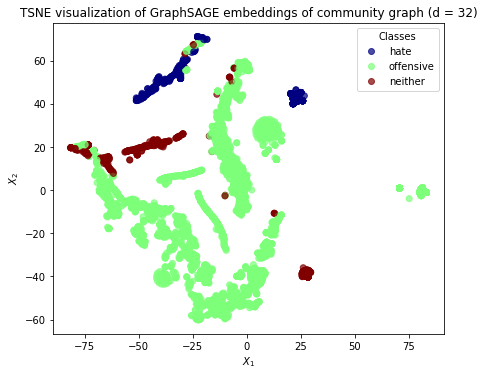

In [352]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
scatter = ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"],
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
legend = ax.legend(scatter.legend_elements()[0], ["hate", "offensive", "neither"], loc='upper right', title='Classes')
plt.title(
    "TSNE visualization of GraphSAGE embeddings of community graph (d = {})".format(EMBEDDING_SIZE)
)
plt.show()

Hyperparamter Tuning:
- learning rate
- embedding size (aktuell 32)
- length of walk (in neighbour sampler)
- feature selection (two features vs four features)
- sizes (in train loader)
- number of layers
- number of epochs

Further to dos:
Implementation of bidirectional graph


In [360]:

pd.DataFrame(emb_transformed).to_excel("./check.xls")
